Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

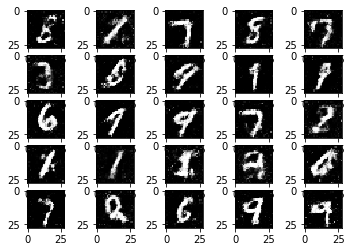

In [1]:
# 필요한 라이브러리를 불러들임
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST 데이터를 읽어들임
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# 학습 관련 매개변수 설정
n_noise = 100 # 입력 잡음신호의 차원
n_h1 = 150 # 첫 번째 은닉층의 은닉노드 개수
n_h2 = 300 # 두 번째 은닉층의 은닉노드 개수
batch_size = 256 # 미니배치 크기
n_epoch = 50000 # 에포크 횟수
#----------------------------------------------
# 생성자 정의: 잡음신호를 입력으로 받아 진짜 데이터와 유사한 가짜 데이터 생성
#----------------------------------------------
def generator(z_noise):
    w1 = tf.Variable(tf.truncated_normal([n_noise,n_h1],stddev=0.1), name="w1_g",
    dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([n_h1]),name="b1_g",dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(z_noise, w1) + b1)
    w2 = tf.Variable(tf.truncated_normal([n_h1,n_h2],stddev=0.1),name="w2_g",
    dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([n_h2]),name="b2_g",dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1,w2) + b2)
    w3 = tf.Variable(tf.truncated_normal([n_h2,28*28],stddev=0.1),name="w3_g",
    dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([28*28]),name="b3_g",dtype=tf.float32)
    h3 = tf.matmul(h2,w3) + b3
    out_gen = tf.nn.tanh(h3)
    weight_g = [w1, b1, w2, b2, w3, b3]
    return out_gen, weight_g
#----------------------------------------------
# 판별자 정의: 진짜 이미지와 가짜 이미지 분류
#----------------------------------------------
def discriminator(x,out_gen,keep_prob):
    x_all = tf.concat([x,out_gen], 0)
    w1 = tf.Variable(tf.truncated_normal([28*28,n_h2],stddev=0.1),name="w1_d",
    dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([n_h2]),name="b1_d",dtype=tf.float32)
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_all,w1) + b1),keep_prob)
    w2 = tf.Variable(tf.truncated_normal([n_h2,n_h1],stddev=0.1),name="w2_d",
    dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([n_h1]),name="b2_d",dtype=tf.float32)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1,w2) + b2),keep_prob)
    w3 = tf.Variable(tf.truncated_normal([n_h1, 1],stddev=0.1),name="w3_d",
    dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]),name="d_b3",dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0],[batch_size, -1],name=None))
    y_fake = tf.nn.sigmoid(tf.slice(h3,[batch_size, 0],[-1, -1],name=None))
    weight_d = [w1, b1, w2, b2, w3, b3]
    return y_data, y_fake, weight_d
#----------------------------------------
# 텐서플로 연산 및 변수, 손실함수 및 최적화 방법 정의하기
#----------------------------------------
# 플레이스 홀더
x = tf.placeholder(tf.float32,[batch_size, 28*28],name="x_data")
z_noise = tf.placeholder(tf.float32,[batch_size,n_noise],name="z_prior")
#드롭아웃에서 보존 확률
keep_prob = tf.placeholder(tf.float32,name="keep_prob")
# 생성자 출력의 생성 및 가중치 정의
out_gen, weight_g = generator(z_noise)
# 판별자 출력 및 가중치 정의
y_data, y_fake, weight_d = discriminator(x,out_gen,keep_prob)
# 판별자와 생성자를 위한 손실함수 및 최적화
disc_loss = - (tf.log(y_data) + tf.log(1 - y_fake))
gen_loss = - tf.log(y_fake)
optimizer = tf.train.AdamOptimizer(0.0001)
d_trainer = optimizer.minimize(disc_loss,var_list=weight_d)
g_trainer = optimizer.minimize(gen_loss,var_list=weight_g)

#----------------------------------------
# 텐서플로 그래프 생성 및 학습
#----------------------------------------
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
z_sample = np.random.uniform(-1,1,size=(batch_size,n_noise)).astype(np.float32)
for epoch in range(n_epoch):
    batch_x, _ = mnist.train.next_batch(batch_size)
    x_value = 2*batch_x.astype(np.float32) - 1
    z_value = np.random.uniform(-1,1,size=(batch_size,n_noise)).astype(np.float32)
    sess.run(d_trainer,feed_dict={x:x_value,z_noise:z_value,keep_prob:0.7})
    sess.run(g_trainer,feed_dict={x:x_value,z_noise:z_value,keep_prob:0.7})
    [c1,c2] = sess.run([disc_loss,gen_loss],feed_dict={x:x_value,z_noise:z_value,
            keep_prob:0.7})
    if epoch % 1000 ==0:
        print("on epoch{}".format(epoch))
#----------------------------------------
# 가짜 이미지 생성 및 한 묶음의 가짜 이미지 그리기
#----------------------------------------
out_img = sess.run(out_gen,feed_dict={z_noise:z_sample})
imgs = 0.5*(out_img + 1)
for k in range(25):
    plt.subplot(5,5,k+1)
    image = np.reshape(imgs[k],(28,28))
    plt.imshow(image,cmap='gray')